# Introduction



### Wohoo! Under 70 days until the World Cup starts in Russia! 

###### This tutorial includes data collection, initial visualization, data processing, feature engineering, modeling, training, predicting and visualization of a dataset.

The dataset is a collection of all the international soccer matches that have taken place (till Jan 2018). 

Using all this data, along with other datasets and FIFA's official World Cup ranking points metric, we will be constructing our own features based on every team's performance over the years.
We will be using **Multiple Linear Regression** to analyze and predict the performance of teams this June and July! 

If you are interested in how FIFA rankings work and the basis behind everything, these two links will be helpful!
* https://en.wikipedia.org/wiki/FIFA_World_Rankings
* http://www.fifa.com/fifa-tournaments/statistics-and-records/worldcup/teams/index.html


Let's get started by importing our libraries!

In [51]:
import pandas as pda
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Link to all the CSV files I use in this tutorial: https://github.com/nikhilrangarajan/Practical-Data-Science-Tutorial

#### Read the CSV File containing the results of all the international soccer matches that have ever taken place (upto January 2018).
###### Let's figure out the format of the dataset, how it is ordered, and the basic structure of the rows and columns of it.

In [52]:
df = pd.read_csv("results.csv")
print (df.shape)
df.head()

(38759, 8)


,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


There are a total of 38759 international soccer matches that have been officially recorded up till today.

## Initial Visualization

#### We notice that the date, the teams, the score, type of tournament and venue of the match is present in the dataset. 

Let's try to visualize the number of goals scored on average per game over the years, just to get a basic idea of this dataset and how trends in soccer have changed over the years - how tactics have changed, the improvement of defending, the offside rule, etc..

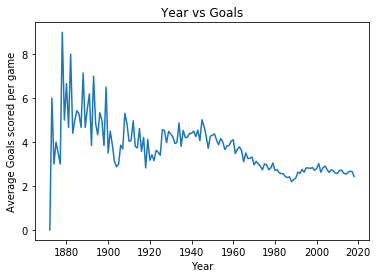

In [53]:
dates = pd.to_datetime(df["date"])
dates = pd.DatetimeIndex(dates).year
df["year"] = dates
a = df.groupby("year").mean()
goals_scored_by_year = a["home_score"] + a["away_score"]
plt.plot(goals_scored_by_year)
plt.xlabel("Year")
plt.ylabel("Average Goals scored per game")
plt.title("Year vs Goals")
plt.show()

Clearly, we can see that the average number of goals scored over the years has reduced. This is due to better tactics, better defence, addition of the offside rule, etc.



Let's see how many games have been played over the years.

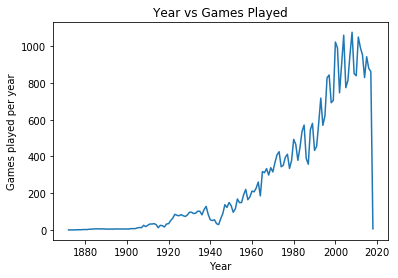

In [54]:
obj = df.groupby("year").count()
plt.plot(obj["date"])
plt.xlabel("Year")
plt.ylabel("Games played per year")
plt.title("Year vs Games Played")
plt.show()

Woah! Almost a 1000 games a year in recent times. This plot looks to be the exact mirror image of the one above!

#### Since we are trying to predict the outcome of the World Cup, we should try to eliminate all "friendly" matches and only evaluate team's performace on competitive matches. 

In [55]:
newdf = df[df.tournament != "Friendly"]
print (newdf.shape)

(22509, 9)


Without friendlies, there have been a total of 22509 competitive games that have been played. That's still quite a lot!

#### Let's try to get some basic information and summary on our new dataframe.

In [56]:
newdf.describe()

,home_score,away_score,year
count,22509.000000,22509.000000,22509.000000
mean,1.750056,1.182283,1991.632058
std,1.799530,1.448682,21.824354
min,0.000000,0.000000,1884.000000
25%,0.000000,0.000000,1981.000000
50%,1.000000,1.000000,1997.000000
75%,2.000000,2.000000,2008.000000
max,31.000000,22.000000,2017.000000


## Start of Adding New Features (Feature Engineering)

We'll define a new column in our dataframe called "win". 
According to a simple formula, we will assign 1 point for every victory and 0.5 points for every draw. We will assign this from the perspective of the home team.

In [57]:
newdf["win"] = 1 * (newdf["home_score"] > newdf["away_score"]) + 0.5 * (newdf["home_score"] == newdf["away_score"])


In [58]:
newdf.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,year,win
29,1884-01-26,Northern Ireland,Scotland,0,5,British Championship,Belfast,Ireland,1884,0.0
30,1884-02-09,Wales,Northern Ireland,6,0,British Championship,Wrexham,Wales,1884,1.0
31,1884-02-23,Northern Ireland,England,1,8,British Championship,Belfast,Ireland,1884,0.0
32,1884-03-15,Scotland,England,1,0,British Championship,Glasgow,Scotland,1884,1.0
33,1884-03-17,Wales,England,0,4,British Championship,Wrexham,Wales,1884,0.0


Let's now create a set of all the international teams that have ever played a competitive game.

In [59]:
hometeams = newdf.home_team.unique()
awayteams = newdf.away_team.unique()
allteams = set(hometeams) | set(awayteams)
print (len(allteams))

236


###### A big pitfall is the fact that some countries don't exist anymore such as Yugoslavia and USSR. :(

So now we have to adjust some of our features and data! 
Let's import a csv file of all the official countries present in the modern day, and compare that with out set. 

In [60]:
countries = pd.read_csv("country.csv", encoding = "utf-16")
print (countries.head())

        Countries
0     Afghanistan
1         Albania
2  American Samoa
3         Algeria
4         Andorra


In [61]:
valid_countries = set(countries["Countries"].tolist())
allteams = allteams & valid_countries
print (len(allteams))

201


We now have a set of around 201 valid soccer playing countries, as of 2018.


Now we tally every single match played by a country, and see the average winning points they got totally (win = 1, draw = 0.5).
We discard every nation that has played less than 20 competitive matches in its history.

In [62]:
country_dict = dict.fromkeys(allteams, 0)
for team in allteams:
    team_df_home = newdf.loc[newdf["home_team"] == team]
    team_df_away = newdf.loc[newdf["away_team"] == team]
    netwins =  team_df_home["win"].sum() + (1 - team_df_away["win"]).sum()
    netmatches = len(team_df_home["win"]) + len(team_df_away["win"])
    if (netmatches < 20):
        prob = 0
    else:
        prob = netwins/netmatches
    country_dict[team] = prob

For example, let us look at the win percentage of Germany over the years.

In [63]:
print (country_dict["Germany"] * 100)

77.12328767123287


Normalize the probabilities and calculate weights for every team, using the winning percentages we initially created.

Weights (Normalized) = Winning_Percentage * (1/ Sum of All Winning_Percentages)

In [64]:
factor = 1.0/sum(country_dict.values())
weights = dict()
for elem in country_dict:
    weights[elem] = country_dict[elem] * factor * 10


Now, let's drop all matches that were played by nations that don't exist anymore, such as Yugoslavia and Czechoslovakia.
Additionally, there are new nations that didn't exist before, such as South Sudan.

Now there are around ~19000 records of games. 

In [65]:
for index, row in newdf.iterrows():
    if (row["home_team"] not in allteams):
        newdf.drop(index, inplace = True)
for index, row in newdf.iterrows():        
    if (row["away_team"] not in allteams):
        newdf.drop(index, inplace = True)
print (newdf.shape)

(19947, 10)


-

###### Using the normalized weights, we calculate another feature.

Wins against strong opposition, such as Germany or Italy is obviously a bigger deal that lower ranked nations. As a result, we also need to calculate weights of victories against the type of opposition, with a higher value given to teams that beat a top-ranked team.

In [66]:
opp = dict()
for team in allteams:
    team_df_home = newdf.loc[newdf["home_team"] == team]
    net_home = [weights[d] for d in team_df_home["away_team"]]
    team_df_home["net"] = net_home
    
    team_df_away = newdf.loc[newdf["away_team"] == team]
    net_away = [weights[d] for d in team_df_away["home_team"]]
    team_df_away["net"] = net_away
    
    
    netH = team_df_home["win"] * team_df_home["net"] * 10
    netA = (1 - team_df_away["win"]) * team_df_away["net"] * 10
    total = (netH.sum() + netA.sum())/(len(netH) + len(netA))
    opp[team] = total * 2

Let us have a look at how Germany has done with respect to the opposition that it has faced over the years.

In [67]:
print(opp["Germany"] * 100)

86.91421617228956


However, we realize that different countries play in different divisions. Naturally, teams from South America and Europe are way more experienced and are more difficult opponents than teams from other nations. So, we have to add some additional features to our dataframe and initialize teams based on their weights of confederations. 

In [68]:
confederations = pd.read_csv("confederations.csv")

In [69]:
confederations.head()

,confederation,name,fifa_code,ioc_code
0,AFC,Afghanistan,AFG,AFG
1,UEFA,Albania,ALB,ALB
2,CAF,Algeria,ALG,ALG
3,OFC,American Samoa,ASA,ASA
4,UEFA,Andorra,AND,AND


We notice that the confederation that every team belongs to is present in this csv file.
    

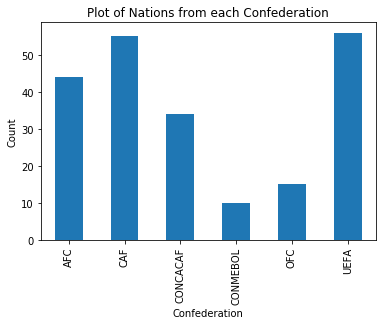

In [70]:
obj1 = confederations.groupby("confederation").count()
foo = obj1["name"].plot(kind = "bar")
plt.xlabel("Confederation")
plt.ylabel("Count")
plt.title("Plot of Nations from each Confederation")
plt.show()

In [71]:
outDF = pd.DataFrame.from_dict(country_dict, orient="index")
outDF.reset_index(level = 0, inplace = True)
oppDF = pd.DataFrame.from_dict(opp, orient="index")
oppDF.reset_index(level = 0, inplace = True)
oppDF["probs"] = outDF[0]
oppDF["opponents"] = oppDF[0] * 2
del oppDF[0]
oppDF["conf"] = 0

According to the weights of confederations - according to FIFA, we will assign the weights of every team.

Naturally, teams from Europe and South America have a higher weightage.

https://en.wikipedia.org/wiki/FIFA_World_Rankings

In [72]:
confederations["confWeight"] = 0
def conf(x):
    if "AFC" in x or "CAF" in x or "OFC" in x or "OFC" in x or "CONCACAF" in x :
        return 0.85
    elif "UEFA" in x:
        return 0.99
    elif "CONMEBOL" in x:
        return 1.0   
confederations["confWeight"] = confederations["confederation"].apply(conf)

In [73]:
a = []
for team in oppDF["index"]:
    try:
        a.append(float(confederations[confederations["name"] == team]["confWeight"]))
    except:
        a.append(0)
oppDF["conf"] = pd.Series(a)

In [74]:
oppDF.head()

,index,probs,opponents,conf
0,Oman,0.441558,0.923450,0.85
1,Ethiopia,0.427966,0.810996,0.85
2,Papua New Guinea,0.434524,0.661539,0.85
3,East Timor,0.166667,0.236399,0.85
4,France,0.674174,1.533178,0.99


By feature engineering, we have managed to add 3 features based on our dataset so far:

* Total Win Rate
* Strength of Opposition
* Confederation

According to FIFA's ranking system, we can extract some more data about how teams have fared in the world cup and add these features. 
FIFA assigns points to each nation that has ever been in the World cup. We can use this feature along with additional features as our training output for linear regression. 
http://www.fifa.com/fifa-tournaments/statistics-and-records/worldcup/teams/index.html

In [75]:
points = pd.read_csv("points.csv")
points.head()

,Rank,Team,Matches Played,Wins,Draws,Losses,Goals for,Goals against,Points,Ave. points,Appearances,Trophies,Runner-Ups
0,1,Brazil,104,70,17,17,221,102,227,2.18,20,5,2
1,2,Germany,106,66,20,20,224,121,218,2.05,18,4,4
2,3,Italy,83,45,21,17,128,77,156,1.88,18,4,2
3,4,Argentina,77,42,14,21,131,84,140,1.84,16,2,3
4,5,Spain,59,29,12,18,92,66,99,1.68,14,1,0


###### Let us do some visualiation.

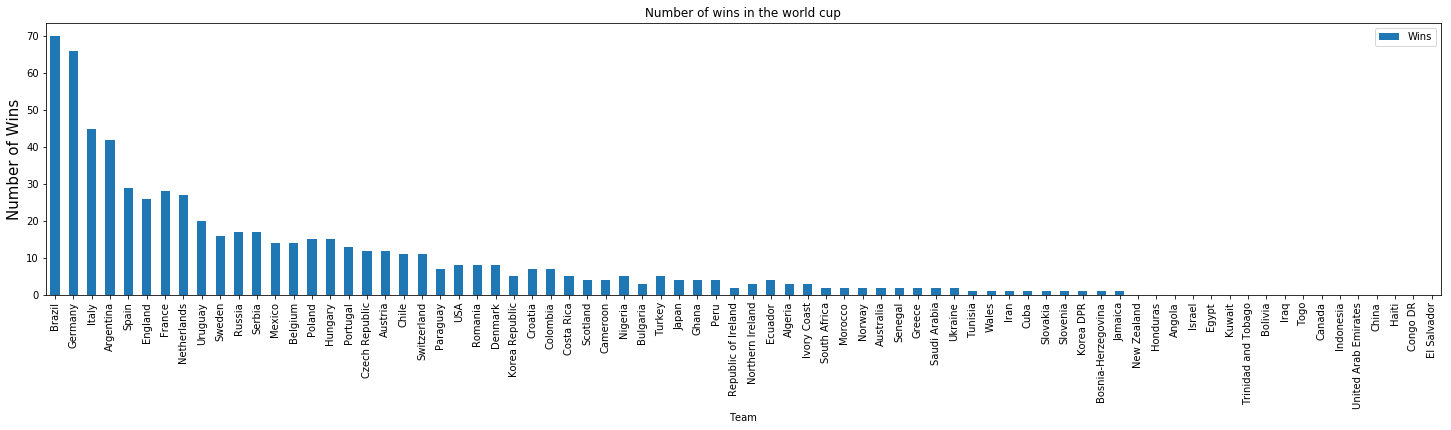

In [76]:
vis = points.copy()
vis.set_index(["Team"], inplace = True)
odds = vis["Wins"].plot(kind = "bar", figsize = (25, 5), title = "Number of wins in the world cup", rot = 90, legend = True)
odds.set_ylabel("Number of Wins", fontsize = 15)
plt.show()

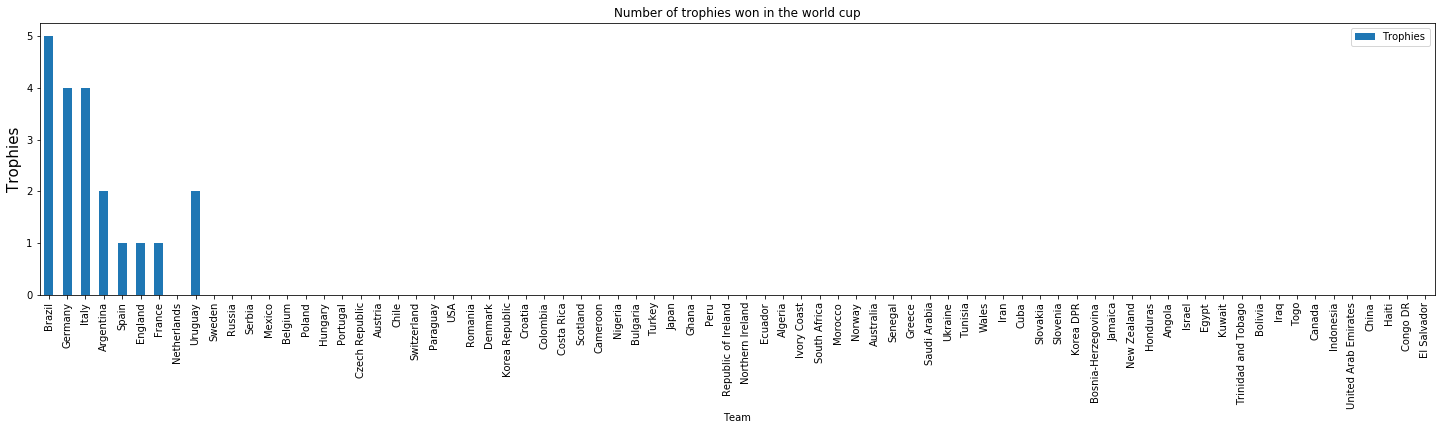

In [77]:
odds = vis["Trophies"].plot(kind = "bar", figsize = (25, 5), title = "Number of trophies won in the world cup", rot = 90, legend = True)
odds.set_ylabel("Trophies", fontsize = 15)
plt.show()

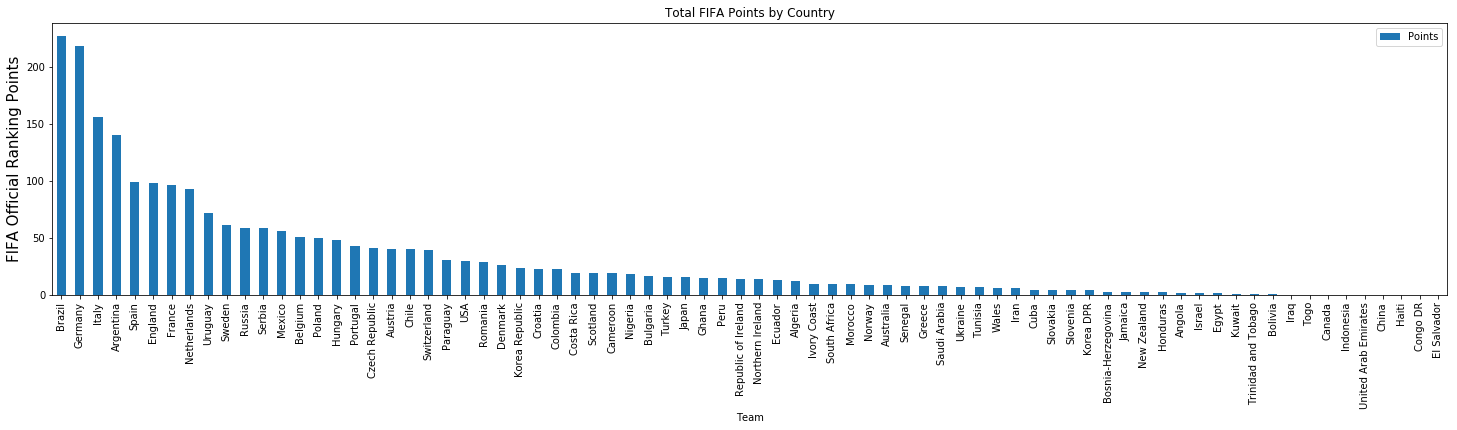

In [78]:
odds = vis["Points"].plot(kind = "bar", figsize = (25, 5), title = "Total FIFA Points by Country", rot = 90, legend = True)
odds.set_ylabel("FIFA Official Ranking Points", fontsize = 15)
plt.show()

Now we can calculate more features by finding out average goals scored per game and average goals conceded per game.

In [79]:
points["GoalRate"] = points["Goals for"] / points["Matches Played"]
points["ConcedeRate"] = points["Goals against"] / points["Matches Played"]
points.head()

,Rank,Team,Matches Played,Wins,Draws,Losses,Goals for,Goals against,Points,Ave. points,Appearances,Trophies,Runner-Ups,GoalRate,ConcedeRate
0,1,Brazil,104,70,17,17,221,102,227,2.18,20,5,2,2.125000,0.980769
1,2,Germany,106,66,20,20,224,121,218,2.05,18,4,4,2.113208,1.141509
2,3,Italy,83,45,21,17,128,77,156,1.88,18,4,2,1.542169,0.927711
3,4,Argentina,77,42,14,21,131,84,140,1.84,16,2,3,1.701299,1.090909
4,5,Spain,59,29,12,18,92,66,99,1.68,14,1,0,1.559322,1.118644


We will extract some of the columns of this dataset and use them as features as well.  
The points column will be our prediction output, which will be explained further below.

In [80]:
features = points.loc[:, ["Team", "Trophies", "Runner-Ups", "GoalRate", "ConcedeRate"]]
a = []
b = []
c = []
for team in features["Team"]:
    if (team in list(oppDF["index"])):
        a.append(float(oppDF[oppDF["index"] == team]["probs"]))
        b.append(float(oppDF[oppDF["index"] == team]["opponents"]))
        c.append(float(oppDF[oppDF["index"] == team]["conf"]))
    else:
        a.append(0)
        b.append(0)
        c.append(0)
features["OverallWin%"] = pd.Series(a)
features["Opp Toughness"] = pd.Series(b)
features["Confederation"] = pd.Series(c)
features["Points"] = points["Points"]

In [81]:
features.head()

,Team,Trophies,Runner-Ups,GoalRate,ConcedeRate,OverallWin%,Opp Toughness,Confederation,Points
0,Brazil,5,2,2.125000,0.980769,0.706215,1.660357,1.00,227
1,Germany,4,4,2.113208,1.141509,0.771233,1.738284,0.99,218
2,Italy,4,2,1.542169,0.927711,0.697007,1.600631,0.99,156
3,Argentina,2,3,1.701299,1.090909,0.674536,1.555623,1.00,140
4,Spain,1,0,1.559322,1.118644,0.731672,1.623355,0.99,99


## Multiple Linear Regression

Linear regression is a linear approach for modelling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X.
For more than one explanatory variable, the process is called multiple linear regression.
Formally, the model for multiple linear regression, given n observations, is 
Yi = a(Xi1) +  b(Xi2) + ... p(Xip) +  i for i = 1,2, ... n. 

We will now use linear regression to predict the weights of every feature in determining the points (Y, the response variable).
The error function that we will be using is Residual Sum of Squares error.


#### Y(points) = a(Trophies) + b(Runner-Ups) + c(GoalRate) + d(ConcedeRate) + e(OverallWin%) + f(OppToughness) + g(Confederations)

In [82]:
X_features = features.iloc[:, 1:8].as_matrix()
y_features = features.iloc[:, 8].as_matrix()
y_features = y_features * 5 


We will now implement the linear regression using Scikit-Learn and the Linear Model Library.

In [83]:
regr = linear_model.LinearRegression()
regr.fit(X_features, y_features)
print (regr.coef_)

[ 150.02737542   61.02638005   93.97977729  -16.66396875   31.69824587
   42.73126986    1.61239028]


These are the respective coefficients of our linear regression.

Approximately,
~ Y(points) = 150(Trophies) + 61(Runner-Ups) + 94(GoalRate) - 16(ConcedeRate) + 31(OverallWin%) + 42(OppToughness) + 1.6(Confederations) 

## Testing and Predicting

Since we are predicting the outcome of the World Cup, let's just consider the teams that are participating in this edition's world cup. We get this from the WorldCup fixture list of the first round.

In [84]:
firstround = pd.read_csv("firstround.csv")
firstround.head()

,Round Number,Date,Location,Home Team,Away Team,Group
0,1,14/06/2018 18:00,"Luzhniki Stadium, Moscow",Russia,Saudi Arabia,Group A
1,1,15/06/2018 15:00,Ekaterinburg Stadium,Egypt,Uruguay,Group A
2,1,15/06/2018 18:00,Saint Petersburg Stadium,Morocco,Iran,Group B
3,1,15/06/2018 21:00,"Fisht Stadium, Sochi",Portugal,Spain,Group B
4,1,16/06/2018 13:00,Kazan Arena,France,Australia,Group C


In [85]:
teams = set(firstround["Home Team"]) | set(firstround["Away Team"])
print (len(teams))

32


32 teams playing this World Cup. Seems about right!

-

We will now construct our test data. We only care about the performance of teams between the last world cup and now. So let's extract all matches played after the 13th of July, 2014.

After that, we shall drop all games that have taken place which doesn't include a team playing this world cup.

In [86]:
after = newdf[newdf["date"] > '2014-07-13']

In [87]:
after.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,year,win
35605,2014-07-19,Botswana,Guinea-Bissau,2,0,African Cup of Nations qualification,Gaborone,Botswana,2014,1.0
35606,2014-07-19,Sierra Leone,Seychelles,2,0,African Cup of Nations qualification,Freetown,Sierra Leone,2014,1.0
35607,2014-07-19,Uganda,Mauritania,2,0,African Cup of Nations qualification,Kampala,Uganda,2014,1.0
35608,2014-07-20,Benin,Malawi,1,0,African Cup of Nations qualification,Cotonou,Benin,2014,1.0
35609,2014-07-20,Congo,Rwanda,2,0,African Cup of Nations qualification,Pointe-Noire,Congo,2014,1.0


In [88]:
for index, row in after.iterrows():
    if (row.home_team in teams or row.away_team in teams):
        continue
    else:
        after.drop(index, inplace = True)

In [89]:
len(after)

699

In [90]:
recent = pd.DataFrame(list(teams))
recent["GoalRate"] = 0
recent["ConcedeRate"] = 0
recent["OverallWin%"] = 0
recent["Opp Toughness"] = 0

For the games played in the last 4 years - we will nowcalculate all the necessary features.
* Goal Rate
* Concede Rate
* Overall Win Rate
* Opposition Toughness

In [91]:
index = 0
for team in recent[0]:
    team_df_home = after.loc[after["home_team"] == team]
    team_df_away = after.loc[after["away_team"] == team]
    netwins =  team_df_home["win"].sum() + (1 - team_df_away["win"]).sum()
    netmatches = len(team_df_home["win"]) + len(team_df_away["win"])
    prob = netwins/netmatches
    recent.iloc[index, 3] = prob
    net_home = [weights[d] for d in team_df_home["away_team"]]
    team_df_home["net"] = net_home
    net_away = [weights[d] for d in team_df_away["home_team"]]
    team_df_away["net"] = net_away 
    netH = team_df_home["win"] * team_df_home["net"] * 10
    netA = (1 - team_df_away["win"]) * team_df_away["net"] * 10
    total = (netH.sum() + netA.sum())/(len(netH) + len(netA))
    recent.iloc[index, 4] = total * 2  
    goals = ((team_df_home["home_score"].sum()) + team_df_away["away_score"].sum()) / (len(team_df_home) + len(team_df_away)) 
    goals_against = ((team_df_home["away_score"].sum()) + team_df_away["home_score"].sum()) / (len(team_df_home) + len(team_df_away)) 
    recent.iloc[index, 1] = goals
    recent.iloc[index, 2] = goals_against
    index += 1
    

##### Now we have data for all teams between 2014 and 2018

In [92]:
recent.head()

,0,GoalRate,ConcedeRate,OverallWin%,Opp Toughness
0,Tunisia,1.742857,0.914286,0.685714,0.710974
1,Germany,2.653846,0.769231,0.807692,0.861686
2,Poland,2.227273,1.136364,0.750000,0.837168
3,Denmark,1.750000,0.833333,0.625000,0.632286
4,Portugal,1.785714,0.571429,0.821429,0.899722


In [93]:
recent["Trophies"] = 0
recent["Confederation"] = 0
recent["Runner-Ups"] = 0

In [94]:
for i in range(len(recent)):
    team = recent.iloc[i, 0]
    try:
        recent.iloc[i, 5] = (int(features[features["Team"] == team].Trophies))
        recent.iloc[i, 7] = (int(features[features["Team"] == team]["Runner-Ups"]))
        recent.iloc[i, 6] = (float(features[features["Team"] == team].Confederation))
    except:
        recent.iloc[i, 6] = (float(oppDF[oppDF["index"] == team].conf))
        
        


In [95]:
cols = recent.columns.tolist()
cols = [(cols[0])] + [cols[5]] + [cols[7]] + cols[1:5] + [cols[6]]
recent = recent[cols]
recent.head()

,0,Trophies,Runner-Ups,GoalRate,ConcedeRate,OverallWin%,Opp Toughness,Confederation
0,Tunisia,0,0,1.742857,0.914286,0.685714,0.710974,0.85
1,Germany,4,4,2.653846,0.769231,0.807692,0.861686,0.99
2,Poland,0,0,2.227273,1.136364,0.750000,0.837168,0.99
3,Denmark,0,0,1.750000,0.833333,0.625000,0.632286,0.99
4,Portugal,0,0,1.785714,0.571429,0.821429,0.899722,0.99


## Prediction

Construct our X_test data using all games played from 2014-2018.

In [96]:
X_predict = recent.iloc[:, 1:8].as_matrix()
y = regr.predict(X_predict)
recent["Predictions"] = pd.DataFrame(y)
ordered = recent.sort_values("Predictions", ascending = False)

Using the coefficients obtained from the Linear Regression previously, we now use that on our test data and check out the estimated points.

In [97]:
ordered.head()

,0,Trophies,Runner-Ups,GoalRate,ConcedeRate,OverallWin%,Opp Toughness,Confederation,Predictions
1,Germany,4,4,2.653846,0.769231,0.807692,0.861686,0.99,1101.084875
29,Brazil,5,2,1.888889,0.666667,0.722222,0.678712,1.00,1048.366265
6,Argentina,2,3,1.791667,0.541667,0.750000,0.749411,1.00,656.158187
23,Spain,1,0,2.666667,0.416667,0.854167,0.741233,0.99,410.303266
16,Uruguay,2,0,1.333333,1.166667,0.472222,0.510569,1.00,400.578876


Calculate the percentage chance of every team winning the world cup.

In [98]:
# Normalize
count = 0
for elem in recent["Predictions"]:
    count += elem
factor = 1.0/count
ordered["Odds"] = ordered["Predictions"] * factor * 100

In [99]:
ordered

,0,Trophies,Runner-Ups,GoalRate,ConcedeRate,OverallWin%,Opp Toughness,Confederation,Predictions,Odds
1,Germany,4,4,2.653846,0.769231,0.807692,0.861686,0.99,1101.084875,13.099661
29,Brazil,5,2,1.888889,0.666667,0.722222,0.678712,1.00,1048.366265,12.472465
6,Argentina,2,3,1.791667,0.541667,0.750000,0.749411,1.00,656.158187,7.806346
23,Spain,1,0,2.666667,0.416667,0.854167,0.741233,0.99,410.303266,4.881398
16,Uruguay,2,0,1.333333,1.166667,0.472222,0.510569,1.00,400.578876,4.765706
9,France,1,1,1.823529,0.647059,0.794118,0.872486,0.99,391.957698,4.663140
17,England,1,0,2.208333,0.416667,0.875000,0.782092,0.99,369.635561,4.397572
26,Belgium,0,0,2.652174,0.695652,0.804348,0.712045,0.99,251.438470,2.991376
14,Japan,0,0,2.241379,0.689655,0.724138,0.831078,0.85,215.250187,2.560842
5,Australia,0,0,2.225806,0.838710,0.741935,0.887485,0.85,214.277317,2.549268


## Visualization of our Predicted Percentages

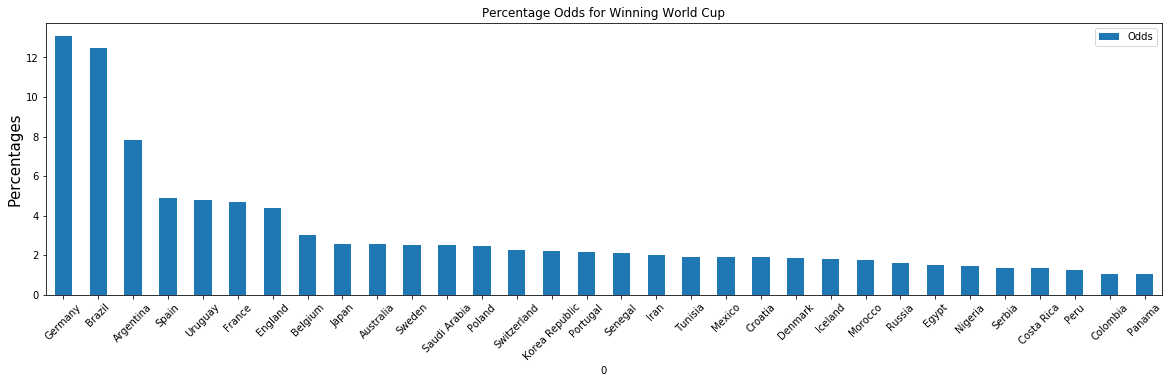

In [100]:
ordered.set_index([0], inplace = True)
odds = ordered["Odds"].plot(kind = "bar", figsize = (20, 5), title = "Percentage Odds for Winning World Cup", rot = 45, legend = True)
odds.set_ylabel("Percentages", fontsize = 15)
plt.show()

###  So clearly, we can see that Germany, Brazil, Argentina and Spain have the best odds to win the cup. On the other hand, first timers Panama, have the lowest odds to win it - based on this Linear Regression Model
### Will Germany retain the crown? Will Messi finally win that World Cup that has eluded his illustrious career? Or will England finally silience their critics and cause a major upset?

## June 14th, 2018. I'll see you there! Let's see how our Model will fare! 